In [1]:
!pip install gensim

In [2]:
import pickle
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [3]:
glove_file = datapath('/content/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.txt")

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-28 13:47:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-28 13:47:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-28 13:47:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
!unzip -o glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [6]:
import numpy as np
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [7]:
import pickle
pickle.dump({'embeddings_index' : embeddings_index } , open('/content/glove.6B.100d.txt', 'wb'))

In [8]:
from typing import List

In [9]:
MAX_TOKENS = 20000
#MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 1200
EMBEDDING_DIM = 100

In [10]:
def build_vocab(sentences: List[str], sequence_length: int):
  vectorizer = TextVectorization(
    output_sequence_length=sequence_length,
  )
  vectorizer.adapt(sentences)
  vocab = vectorizer.get_vocabulary()
  word_index = dict(zip(vocab, range(len(vocab))))

  return vectorizer, word_index

In [11]:
from keras.layers.preprocessing.text_vectorization import TextVectorization

# Textually Similar

In [12]:
import pandas as pd
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
#importing the CSV file of the dataset from google drive into a dataframe
df_sim=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_textually_similar_test_duplicates_preprocessed.csv')
df_sim = df_sim[df_sim.is_similar.astype('bool')].sample(300)
df_sim= df_sim.sample(300)

In [14]:
df_sim = df_sim.drop(columns=['Unnamed: 0'])
df_sim

,description1,description2,is_similar
1252,affected versions aff...,user agent mozilla gecko firefox ...,1
629,created attachment screen shot at ...,created attachment screenshot str st...,1
1220,since the patch on bug landed the gecko lo...,because of central rev toolkit modules p...,1
1335,affected versions nightly beta ...,created attachment the focus indictor is b...,1
572,created attachment peek user ...,we should try using getboundswithoutflushing...,1
...,...,...,...
1319,created attachment screen shot the small ...,created attachment screenshot the affects...,1
276,affected versions firefox firefox ...,created attachment touchmenusswipe gif ...,1
1203,created attachment bing search results us...,created attachment screen shot at ...,1
617,user agent mozilla gecko firefox ...,tracking requested why for this release ...,1


In [15]:
FEATURES = ['description1', 'description2']

In [16]:
import itertools

In [17]:
descr_vectorizer, descr_word_index = build_vocab(
  [df_sim.description1, df_sim.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'the', 'to', 'a']


In [18]:
descr_vectorizer.vocabulary_size()

4219

In [19]:
from typing import List, Dict, Tuple, Set

In [20]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((descr_vectorizer.vocabulary_size(),EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [21]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (4219, 100)
Found 3649 words, missed 570.


In [22]:
descr_embedding_matrix.shape

(4219, 100)

In [23]:
from sklearn.decomposition import PCA

In [24]:
descr_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 1.03659999, -0.013461  ,  0.061852  , ...,  0.76797998,
         0.94884002,  0.33374   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25736001, -0.28448999,  0.25514999, ..., -0.37619001,
        -0.35448   , -0.063603  ]])

In [25]:
X = descr_embedding_matrix

In [26]:
pip install pyclustertend

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import scale
from pyclustertend import hopkins ## the hopkins test


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [58]:
import math
#Sample data must be preprocessed into dataframe or matrix form before given as the value of parameter "data".

In [59]:
# hopkins(X, X.shape[0])
# hopkins(scale(X),X.shape[0])

In [60]:
# H=hopkins_statistic(X)
# print(H)
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
from numpy.random import uniform

In [61]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
    #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [62]:
l = [] #list to hold values for each call
for i in range(300):
    H=hopkins_statistic(X)
    l.append(H)
#print average value:
print(H)
print(l)

0.7552916825058404
[0.7607636792653527, 0.7555220167605015, 0.7503021480237598, 0.7554600820067223, 0.7601741896177739, 0.7574760838691528, 0.7439259038220635, 0.7584101018306577, 0.7485003174087999, 0.7541700739515115, 0.7616411407601787, 0.7645025866916066, 0.7524097794058386, 0.758306543943755, 0.7631743335770864, 0.7370114154018526, 0.7515161308069893, 0.7584301662581472, 0.7644856519015009, 0.7489797419629854, 0.7551522122050719, 0.7495829950243735, 0.7609056531913903, 0.7647250010565553, 0.7558182209069777, 0.7488149475352969, 0.7549449405867376, 0.7502604501307747, 0.7456968354853726, 0.7533268290287181, 0.7431264844516837, 0.7664632693356569, 0.7506572877163984, 0.7541520003963904, 0.7490031971112953, 0.750978818681303, 0.7592299033371487, 0.7513152206584741, 0.7470011606243252, 0.7504734846039304, 0.7579124388460068, 0.7605510905220692, 0.754521337051847, 0.7602041950472852, 0.7577115821171724, 0.751832500261429, 0.7510504478778033, 0.7587580263035848, 0.762378050683107, 0.751

In [63]:
print('\n'.join(map(str, l)))

0.7607636792653527
0.7555220167605015
0.7503021480237598
0.7554600820067223
0.7601741896177739
0.7574760838691528
0.7439259038220635
0.7584101018306577
0.7485003174087999
0.7541700739515115
0.7616411407601787
0.7645025866916066
0.7524097794058386
0.758306543943755
0.7631743335770864
0.7370114154018526
0.7515161308069893
0.7584301662581472
0.7644856519015009
0.7489797419629854
0.7551522122050719
0.7495829950243735
0.7609056531913903
0.7647250010565553
0.7558182209069777
0.7488149475352969
0.7549449405867376
0.7502604501307747
0.7456968354853726
0.7533268290287181
0.7431264844516837
0.7664632693356569
0.7506572877163984
0.7541520003963904
0.7490031971112953
0.750978818681303
0.7592299033371487
0.7513152206584741
0.7470011606243252
0.7504734846039304
0.7579124388460068
0.7605510905220692
0.754521337051847
0.7602041950472852
0.7577115821171724
0.751832500261429
0.7510504478778033
0.7587580263035848
0.762378050683107
0.7510861767995389
0.7436306661298598
0.7612470558809772
0.750622185454763

In [64]:
len(l)

300

In [65]:
df_sim_hopkin = pd.DataFrame(l)
print(df_sim_hopkin)

            0
0    0.760764
1    0.755522
2    0.750302
3    0.755460
4    0.760174
..        ...
295  0.762791
296  0.754389
297  0.760536
298  0.747159
299  0.755292

[300 rows x 1 columns]


In [66]:
# from sklearn.decomposition import PCA
# data = descr_embedding_matrix
# labels = df_sim.is_similar

# model = PCA(n_components=2)
# # configuring the parameteres

# PCA_data = model.fit_transform(data)

In [67]:
# PCA_data.shape

In [68]:
# # Ploting the result of tsne
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.scatter(PCA_data[:, 0], PCA_data[:, 1])
# plt.savefig('output_similar.jpg')
# plt.show()

In [69]:
plt.savefig('output_similar.png')

<Figure size 432x288 with 0 Axes>

# Textually Dissimilar

In [70]:
#importing the CSV file of the dataset from google drive into a dataframe
df_dissim = pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_textually_dissimilar_test_duplicates_preprocessed.csv')
df_dissim = df_dissim[df_dissim.is_similar.astype('bool')].sample(300)
df_dissim

,Unnamed: 0,description1,description2,is_similar
195,201,filed by wkocher at mozilla com job i...,job id repo mozilla central ...,1
542,558,created attachment hist png user agent m...,created attachment bookmarks scrollbar png...,1
1040,1070,user agent mozilla applewebkit ...,user agent mozilla gecko firefox ...,1
848,872,i don t have a lot to go on here sorry t...,we decided to temporarily back out the new t...,1
1271,1311,markdown filed by ncsoregi at mozilla...,filed by archaeopteryx at coole files de ...,1
...,...,...,...,...
243,250,filed by cbook at mozilla com job id ...,str enable containers in about config ...,1
870,894,filed by ncsoregi at mozilla com pa...,filed by rmaries at mozilla com par...,1
102,107,created attachment site information misali...,created attachment bildschirmfoto um...,1
377,387,created attachment firefox detect portal m...,to reproduce redirect to a url of you...,1


In [71]:
df_dissim = df_dissim.drop(columns=['Unnamed: 0'])
df_dissim

,description1,description2,is_similar
195,filed by wkocher at mozilla com job i...,job id repo mozilla central ...,1
542,created attachment hist png user agent m...,created attachment bookmarks scrollbar png...,1
1040,user agent mozilla applewebkit ...,user agent mozilla gecko firefox ...,1
848,i don t have a lot to go on here sorry t...,we decided to temporarily back out the new t...,1
1271,markdown filed by ncsoregi at mozilla...,filed by archaeopteryx at coole files de ...,1
...,...,...,...
243,filed by cbook at mozilla com job id ...,str enable containers in about config ...,1
870,filed by ncsoregi at mozilla com pa...,filed by rmaries at mozilla com par...,1
102,created attachment site information misali...,created attachment bildschirmfoto um...,1
377,created attachment firefox detect portal m...,to reproduce redirect to a url of you...,1


In [72]:
descr_vectorizer, descr_word_index = build_vocab(
  [df_dissim.description1, df_dissim.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'info', 'task', 'the']


In [73]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((descr_vectorizer.vocabulary_size(), EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [74]:
print('Creating description embedding matrix:')
descr_embedding_matrix1 = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (5616, 100)
Found 4128 words, missed 1488.


In [75]:
descr_embedding_matrix1

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.81967002, -0.14202   ,  0.64740998, ..., -0.55650997,
         0.34254   ,  0.29034999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.69509   , -1.04789996, -0.042288  , ..., -0.48866001,
        -0.21971001, -0.48694   ],
       [-0.28870001, -0.27153   , -0.64012998, ...,  0.017956  ,
        -0.44297001, -0.14222001]])

In [76]:
X1 = descr_embedding_matrix1

In [77]:
#hopkins(scale(X1),X1.shape[0])

In [78]:
#hopkins(X1, X1.shape[0])
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
from numpy.random import uniform

In [79]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X1):
    
     #convert dataframe to a numpy array
    sample_size = int(X1.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X1_uniform_random_sample = uniform(X1.min(axis=0), X1.max(axis=0) ,(sample_size , X1.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X1.shape[0], 1), sample_size)
    X1_sample = X1[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X1)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X1_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X1_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [80]:
l1 = [] #list to hold values for each call
for i in range(300):
    H1=hopkins_statistic(X1)
    l1.append(H1)
#print average value:
print(H1)
print(l1)

0.7895953154371347
[0.7870417801106214, 0.7795077199637322, 0.7819604094136614, 0.7857816237222277, 0.7845708102013553, 0.7785594784203187, 0.7842236056377317, 0.7803960533023968, 0.7787726240711441, 0.7893412078003813, 0.790358897057941, 0.7891802839242477, 0.7827530084904231, 0.7833829107576421, 0.7782838013601221, 0.7744241667266828, 0.7824393946258743, 0.7792850802415855, 0.7824226203560707, 0.781448242256253, 0.7792856794763343, 0.787456090191573, 0.7744317218027384, 0.7814828210770647, 0.784100671297956, 0.7863810449139196, 0.7926569217779664, 0.79304445735098, 0.7824881438873296, 0.7758761145749917, 0.7839304395990963, 0.7843724876836402, 0.7781985126030203, 0.7855006967525092, 0.7827971399808431, 0.7914093250168556, 0.7881121939062559, 0.7899187525880729, 0.7835720179408465, 0.7732743564579986, 0.786101273988913, 0.7907420548079888, 0.7888401179732208, 0.7907789180775043, 0.7877583291980459, 0.7941494271150193, 0.7815434084798129, 0.7758590655962654, 0.7747485337434286, 0.78665

In [81]:
# print in new line
print(l1, sep = "\n")

[0.7870417801106214, 0.7795077199637322, 0.7819604094136614, 0.7857816237222277, 0.7845708102013553, 0.7785594784203187, 0.7842236056377317, 0.7803960533023968, 0.7787726240711441, 0.7893412078003813, 0.790358897057941, 0.7891802839242477, 0.7827530084904231, 0.7833829107576421, 0.7782838013601221, 0.7744241667266828, 0.7824393946258743, 0.7792850802415855, 0.7824226203560707, 0.781448242256253, 0.7792856794763343, 0.787456090191573, 0.7744317218027384, 0.7814828210770647, 0.784100671297956, 0.7863810449139196, 0.7926569217779664, 0.79304445735098, 0.7824881438873296, 0.7758761145749917, 0.7839304395990963, 0.7843724876836402, 0.7781985126030203, 0.7855006967525092, 0.7827971399808431, 0.7914093250168556, 0.7881121939062559, 0.7899187525880729, 0.7835720179408465, 0.7732743564579986, 0.786101273988913, 0.7907420548079888, 0.7888401179732208, 0.7907789180775043, 0.7877583291980459, 0.7941494271150193, 0.7815434084798129, 0.7758590655962654, 0.7747485337434286, 0.7866560781314114, 0.7790

In [82]:
print('\n'.join(map(str, l1)))

0.7870417801106214
0.7795077199637322
0.7819604094136614
0.7857816237222277
0.7845708102013553
0.7785594784203187
0.7842236056377317
0.7803960533023968
0.7787726240711441
0.7893412078003813
0.790358897057941
0.7891802839242477
0.7827530084904231
0.7833829107576421
0.7782838013601221
0.7744241667266828
0.7824393946258743
0.7792850802415855
0.7824226203560707
0.781448242256253
0.7792856794763343
0.787456090191573
0.7744317218027384
0.7814828210770647
0.784100671297956
0.7863810449139196
0.7926569217779664
0.79304445735098
0.7824881438873296
0.7758761145749917
0.7839304395990963
0.7843724876836402
0.7781985126030203
0.7855006967525092
0.7827971399808431
0.7914093250168556
0.7881121939062559
0.7899187525880729
0.7835720179408465
0.7732743564579986
0.786101273988913
0.7907420548079888
0.7888401179732208
0.7907789180775043
0.7877583291980459
0.7941494271150193
0.7815434084798129
0.7758590655962654
0.7747485337434286
0.7866560781314114
0.7790274691976359
0.7897623562714212
0.782521497870192
0

In [83]:
len(l1)

300

In [84]:
df_dissim_hopkin = pd.DataFrame(l1)
print(df_dissim_hopkin)

            0
0    0.787042
1    0.779508
2    0.781960
3    0.785782
4    0.784571
..        ...
295  0.788750
296  0.774337
297  0.790079
298  0.776140
299  0.789595

[300 rows x 1 columns]


In [85]:
df_dissim_hopkin.shape

(300, 1)

In [86]:
#the null hypothesis (no meaningfull cluster) happens when the hopkins test is around 0.5 and the hopkins test tends to 0 when meaningful cluster exists in the space. Usually, we can believe in the existence of clusters when the hopkins score is bellow 0.25.

#Here the value of the hopkins test is quite high but one could think there is cluster in our subspace. BUT the hopkins test is highly influenced by outliers, let's try once again with normalised data.

In [87]:
import seaborn as sns

In [88]:
# # Picking the top 100 points as TSNE takes a lot of time for 15K points
# from sklearn.decomposition import PCA
# data_100 = descr_embedding_matrix1
# labels_100 = df_dissim.is_similar

# # model = PCA(n_components=2)
# # # configuring the parameteres

# PCA_data = model.transform(data_100)

In [89]:
# PCA_data.shape

In [90]:
# # Ploting the result of tsne
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.scatter(PCA_data[:, 0], PCA_data[:, 1])
# plt.savefig('output_similar.jpg')
# plt.show()


## Box plot using hopkin test value for each pair

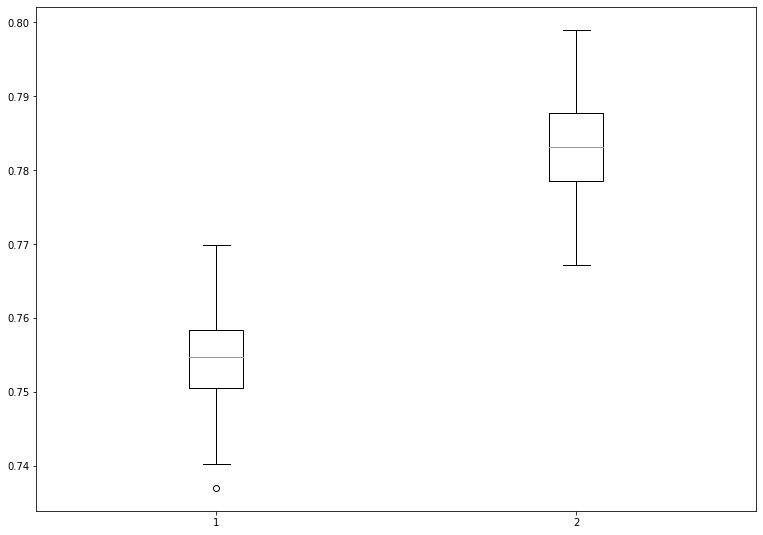

In [91]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
 
data_1 = l
data_2 = l1

data = [data_1, data_2]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

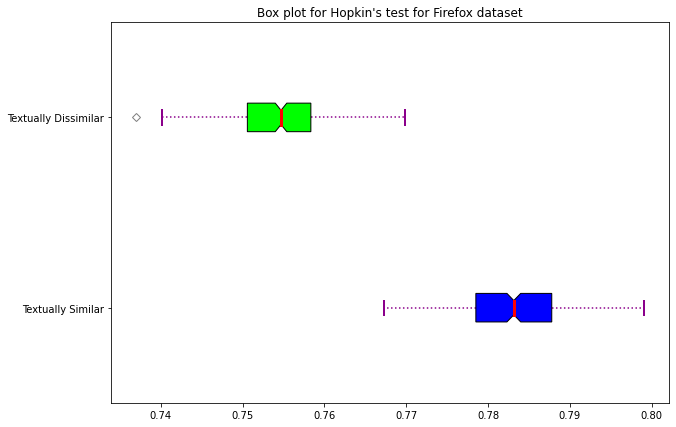

In [92]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = l1 #tex_sim
data_2 = l #tex_dissim

data = [data_1, data_2]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(['Textually Similar', 'Textually Dissimilar'])
 
# Adding title
plt.title("Box plot for Hopkin's test for Firefox dataset")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()